In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Use latex for font rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
models = {"Vanilla": "vanilla", "Vanilla Restricted": "vanilla_restricted", "Mobi": "mobi", "Mobi Restricted": "mobi_restricted"}

results = {}
for k in models.values():
    with open(f"results_{k}/metrics_details.json") as f:
        results[k] = json.load(f)

summary = {}
for k in models.values():
    with open(f"results_{k}/metrics_summary.json") as f:
        summary[k] = json.load(f)

In [3]:
results["vanilla_restricted"].keys()

dict_keys(['car:0.5', 'car:1.0', 'car:2.0', 'car:4.0', 'truck:0.5', 'truck:1.0', 'truck:2.0', 'truck:4.0', 'bus:0.5', 'bus:1.0', 'bus:2.0', 'bus:4.0', 'trailer:0.5', 'trailer:1.0', 'trailer:2.0', 'trailer:4.0', 'construction_vehicle:0.5', 'construction_vehicle:1.0', 'construction_vehicle:2.0', 'construction_vehicle:4.0', 'pedestrian:0.5', 'pedestrian:1.0', 'pedestrian:2.0', 'pedestrian:4.0', 'motorcycle:0.5', 'motorcycle:1.0', 'motorcycle:2.0', 'motorcycle:4.0', 'bicycle:0.5', 'bicycle:1.0', 'bicycle:2.0', 'bicycle:4.0', 'traffic_cone:0.5', 'traffic_cone:1.0', 'traffic_cone:2.0', 'traffic_cone:4.0', 'barrier:0.5', 'barrier:1.0', 'barrier:2.0', 'barrier:4.0'])

In [4]:
metrics = ['trans_err', 'vel_err', 'scale_err', 'orient_err', 'attr_err']
classes = ["car", "pedestrian"]
distances = [0.5, 1.0, 2.0, 4.0]

metric_results = {}
for k in models.values():
    metric_results[k] = {}
    for c in classes:
        metric_results[k][c] = {}
        for m in metrics:
            metric_results[k][c][m] = np.mean([np.mean(results[k][f"{c}:{d}"][m]) for d in distances])

In [5]:
metric_results

{'vanilla': {'car': {'trans_err': 0.17717198586449734,
   'vel_err': 0.23298518307770252,
   'scale_err': 0.15841581996110146,
   'orient_err': 0.10462679317764516,
   'attr_err': 0.07216705596571246},
  'pedestrian': {'trans_err': 0.1254889501269094,
   'vel_err': 0.36006635946909954,
   'scale_err': 0.26245448157269385,
   'orient_err': 0.47650584474468477,
   'attr_err': 0.19013343802583257}},
 'vanilla_restricted': {'car': {'trans_err': 0.1519148266036745,
   'vel_err': 0.3652361236842582,
   'scale_err': 0.1547944636983406,
   'orient_err': 0.07925508286942606,
   'attr_err': 0.10813492063492064},
  'pedestrian': {'trans_err': 0.176109673361955,
   'vel_err': 0.3869413382366472,
   'scale_err': 0.22707340271025536,
   'orient_err': 0.506637417046245,
   'attr_err': 0.22727272727272727}},
 'mobi': {'car': {'trans_err': 0.18446860260791795,
   'vel_err': 0.2450998874020656,
   'scale_err': 0.16742619344885554,
   'orient_err': 0.12184586516706272,
   'attr_err': 0.08083709045990131}

In [6]:
# Make a dataframe with the foloowing structure:
#   - Rows: metrics | car | pedestrian
#   - Columns: models

rows = []
for k in (k for k in models.values() if k.endswith("restricted")):
    rows.append({"model": k, 
    **{f"{m}__{c}": metric_results[k][c][m] for m in metrics for c in classes}})
df = pd.DataFrame(rows)

# Remove vel_err and attr_err
df = df.drop(columns=["vel_err__car", "vel_err__pedestrian", "attr_err__car", "attr_err__pedestrian"])

# Print as latex table

print(df.to_latex(index=False, float_format="%.4f"))

\begin{tabular}{lrrrrrr}
\toprule
model & trans_err__car & trans_err__pedestrian & scale_err__car & scale_err__pedestrian & orient_err__car & orient_err__pedestrian \\
\midrule
vanilla_restricted & 0.1519 & 0.1761 & 0.1548 & 0.2271 & 0.0793 & 0.5066 \\
mobi_restricted & 0.2183 & 0.2889 & 0.1600 & 0.2595 & 0.4138 & 0.6710 \\
\bottomrule
\end{tabular}



Number of confidences for vanilla: 379
Number of confidences for vanilla_restricted: 222
Number of confidences for mobi: 378
Number of confidences for mobi_restricted: 216


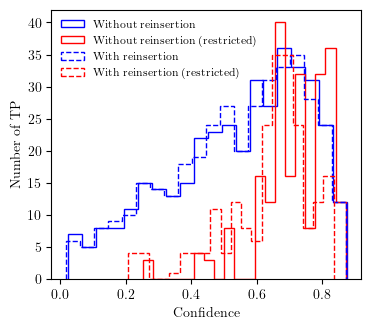

In [33]:
# small figure
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))

for k, data in results.items():
    # Just use a single line for the confidence histogram
    label = {
        "vanilla": "Without reinsertion",
        "vanilla_restricted": "Without reinsertion (restricted)",
        "mobi": "With reinsertion",
        "mobi_restricted": "With reinsertion (restricted)"
    }[k]
    color, style = {
        "vanilla": ("blue", "-"),
        "vanilla_restricted": ("red", "-"),
        "mobi": ("blue", "--"),
        "mobi_restricted": ("red", "--")
    }[k]
    confidence = [c for d in distances for c in data[f"car:{d}"]["confidence"] if c > 0]
    print(f"Number of confidences for {k}: {len(confidence)}")
    plt.hist(confidence, bins=20, histtype='step', label=label, color=color, linestyle=style)
    
# Remove legend box
plt.legend(loc='upper left', frameon=False, fontsize=8)
plt.xlabel("Confidence")
plt.ylabel("Number of TP")

plt.savefig("confidence_histogram.pdf", bbox_inches='tight')